# Morpheus Deblend N-closest sources, no neighborhood

The notebook is laid out as follows:

1. Getting the sample source and scarlet solution from the SCARLET quickstart guide
2. Morpheus Deblend Center Of Mass Code (Not Changed, Included for completeness)
3. Morpheus Deblend Claim Vector/Map Encoder
4. Morpheus Deblend Claim Vecotr/Map Decoder
4. Encode/Decode quickstart image and Visualize Results
5. Diff SCARLET/Morpheus Deblend and Visualize

In [33]:
# user guide from https://pmelchior.github.io/scarlet/0-quickstart.html
from functools import partial
from itertools import product, starmap
from  typing import Callable, List, Tuple

# Import Packages and setup
import flow_vis
import numpy as np
import scarlet
import scarlet.psf as psf
import scarlet.display
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin='lower')
plt.style.use("robertsons_rules")

In [3]:
data = np.load("hsc_cosmos_35.npz")
images = data["images"] # (5, 58, 48)
filters = data["filters"] # ['g', 'r', 'i', 'z', 'y']
catalog = data["catalog"] # List of 2-Tuple, x and y
weights = 1/data["variance"] # (5, 58, 48)
psfs = scarlet.ImagePSF(data["psfs"]) # (5, 43, 43)

findfont: Font family ['afm'] not found. Falling back to DejaVu Sans.


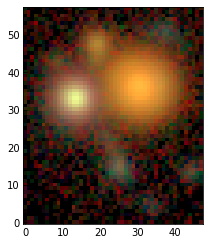

In [4]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [5]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psfs=psfs,
    weights=weights,
    channels=filters).match(model_frame)

findfont: Font family ['afm'] not found. Falling back to DejaVu Sans.


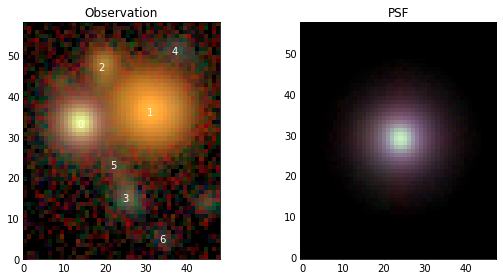

In [6]:
sky_coords = [[src['y'], src['x']] for src in catalog] # y/x!
scarlet.display.show_observation(observation, norm=norm, sky_coords=sky_coords, show_psf=True)
plt.show()

In [7]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    elif k == 1:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, K=2)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, compact=True)
    sources.append(new_source)

CPU times: user 2.93 s, sys: 49.6 ms, total: 2.98 s
Wall time: 3.01 s
scarlet ran for 76 iterations to logL = 30420.93855546932


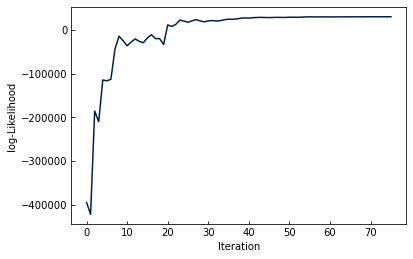

In [8]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

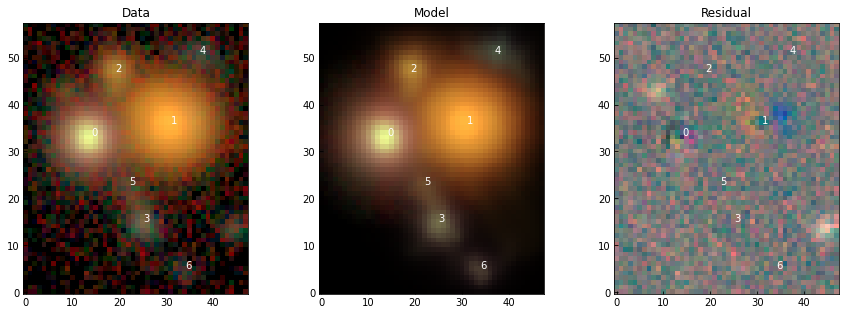

In [9]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# each source rendered in each band
model_vals = [observation.render(sources[i].get_model(frame=sources[i].frame)) for i in range(len(sources))]

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

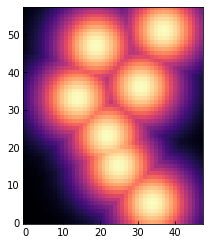

In [10]:
#https://stackoverflow.com/a/46892763/2691018
def gkern(kernlen=21, std=8):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def generate_com(shape:Tuple[int, int], srcs:List[np.ndarray]) -> np.ndarray:
    gk_len = 51
    gk = gkern(gk_len, 8)
    
    com = np.zeros(shape, dtype=np.float32)
    height, width = shape
    for src in catalog:
        y, x = int(src["y"]), int(src["x"])
        half_len = int((gk_len / 2))
        

        big_ys = slice(
            max(y-half_len, 0),
            min(y+half_len, height)
        )
        
        big_xs = slice(
            max(x-half_len, 0),
            min(x+half_len, height)
        )
        
        g_ys = slice(
            half_len - min(half_len, half_len-(half_len-y)),
            half_len + min(half_len, height-y),
        )
        
        g_xs = slice(
            half_len - min(half_len, half_len-(half_len-x)),
            half_len + min(half_len, width-x),
        )
        
        b = com[big_ys, big_xs].copy()
        g = gk[g_ys, g_xs].copy()

        com[big_ys, big_xs] = np.maximum(g, b)

    return com

plt.imshow(generate_com(images.shape[1:], catalog))

In [51]:
def get_n_closest_fw_claim_vectors_single_pixel(
    claim_vectors: np.ndarray,      # [h, w, b, n, 2]
    claim_map: np.ndarray,          # [h, w, b, n]
    model_vals: List[np.ndarray],   # list(n)
    src_centers: np.ndarray,        # [n, 2]
    n: int,
    y: int,
    x: int,
    b: int,
) -> None:
    relative_vectors = src_centers - np.array([y, x]) # [n_srcs, 2]
    relative_distances = np.linalg.norm(relative_vectors, axis=-1) # [n_srcs,]
    normed_distances = relative_distances / relative_distances.max() # [n_srcs, ]

    src_fluxes = np.array([max(model_vals[i][b, y, x], 0) for i in range(len(model_vals))]) # [n_srcs, ]
    normed_flux = src_fluxes / src_fluxes.max() # [n_srcs, ]
    normed_sum_to_one = src_fluxes / src_fluxes.sum() # [n_srcs, ]

    metric = (1 - normed_distances) * normed_flux # [n_srcs, ]

    top_srcs = np.argsort(-metric)[:n]

    num_pad = n - top_srcs.shape[0]
    if num_pad > 0:
        n_closest_sources = top_srcs
    else:
        n_closest_sources = np.pad(top_srcs, (0, num_pad), mode="edge")

    selected_srcs = relative_vectors[n_closest_sources]

    src_fluxes = np.array([max(model_vals[i][b, y, x], 0) for i in top_srcs])

    sum_flux = src_fluxes.sum()
    if sum_flux > 0:
        normed_flux = src_fluxes / sum_flux
    else:
        normed_flux = np.ones([n], dtype=np.float32) / n

    idxs, counts = np.unique(n_closest_sources, return_counts=True)
    coefs = np.reciprocal(counts.astype(np.float32))

    claim = np.array(list(map(
        lambda i: coefs[idxs==i][0] * normed_flux[i==top_srcs][0], 
        n_closest_sources
    )))  

    claim_vectors[y, x, b, ...] = selected_srcs
    claim_map[y, x, b, ...] = claim    

def get_n_brightest_closest_claim_vectors_maps(
    model_vals: List[np.ndarray], #list([b, h, w])
    src_centers: np.ndarray,
    n: int,
) -> Tuple[np.ndarray, np.ndarray]: # [h, w, b, n], [h, w, b, n, 2]
    b, y, x = model_vals[0].shape

    idxs = product(range(y), range(x), range(b))

    claim_vector = np.zeros([y, x, b, n, 2], dtype=np.float32)
    claim_map = np.zeros([y, x, b, n], dtype=np.float32)

    encode_f = partial(
        get_n_closest_fw_claim_vectors_single_pixel,
        claim_vector,
        claim_map,
        model_vals,
        src_centers,
        n,
    )

    for _ in starmap(encode_f, tqdm(idxs, total=y*x*b)):
        pass

    return claim_vector, claim_map

## Morpheus Deblend Claim Vector/Map Decoder

The decoder has a much simpler task than the encoder. The decode, the output magntidudes are multiplied by the neighborhood vectors and then the claim map determines the amount of flux to assign to each source.

In [52]:
def decode_single_pixel(
    output:np.ndarray,
    flux:np.ndarray,
    claim_vector:np.ndarray,
    claim_map:np.ndarray,
    src_centers:np.ndarray,
    y:int,
    x:int,
    b:int,
) -> None:
    pixel_flux = flux[y, x, b]
    pixel_vectors = claim_vector[y, x, b, ...].copy() # [n, 2]
    pixel_claim_map = claim_map[y, x, b, ...].copy() # [n,]

    relative_centers = src_centers - np.array([y, x])

    distances = euclidean_distances(pixel_vectors, relative_centers) #[n, n_src_centers]
    closest_srcs = np.argmin(distances, axis=1)

    distributed_flux = pixel_flux * pixel_claim_map

    def update_output(src_idx:int, flx:float):
        output[src_idx, y, x, b] += flx

    for _ in starmap(update_output, zip(closest_srcs, distributed_flux)):
        pass

def decode(
    flux:np.ndarray, 
    claim_vector:np.ndarray, 
    claim_map:np.ndarray, 
    src_centers:np.ndarray
) -> np.ndarray:
    y, x, b = flux.shape
    output = np.zeros([src_centers.shape[0], y, x, b], dtype=np.float32)

    idxs = product(range(y), range(x), range(b))

    decode_f = partial(
        decode_single_pixel, 
        output, 
        flux, 
        claim_vector, 
        claim_map, 
        src_centers,
    )

    for _ in starmap(decode_f, tqdm(idxs, total=y*x*b)):
        pass

    return output

In [53]:
n = 5
src_centers = np.array([[c["y"], c["x"]] for c in catalog])
claim_vectors, claim_map = get_n_brightest_closest_claim_vectors_maps(model_vals, src_centers, n)

flux = np.transpose(images, axes=(1,2,0))
#output = decode(flux, claim_vectors, claim_map, src_centers)
output = decode(
    np.transpose(sum(model_vals), axes=(1,2,0)), 
    claim_vectors, 
    claim_map, 
    src_centers
)

100%|██████████| 13920/13920 [00:02<00:00, 5302.00it/s]


(0.0, 1.0, 0.0, 1.0)

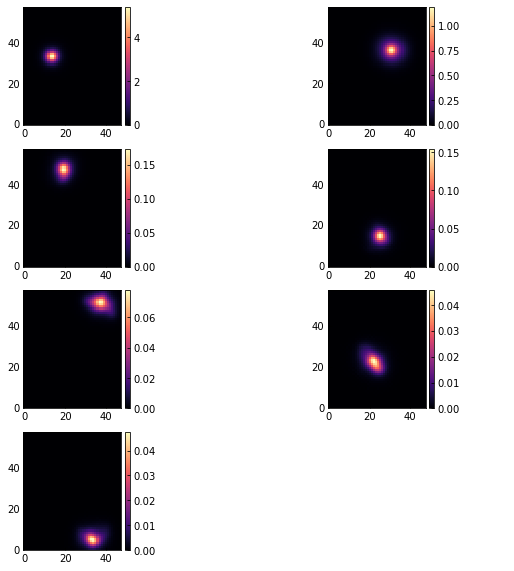

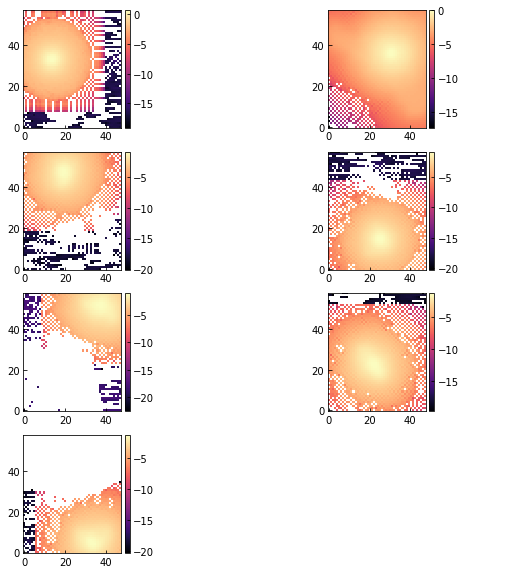

In [54]:
band = 0

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(np.log10(output[i, :, :, band]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

(0.0, 1.0, 0.0, 1.0)

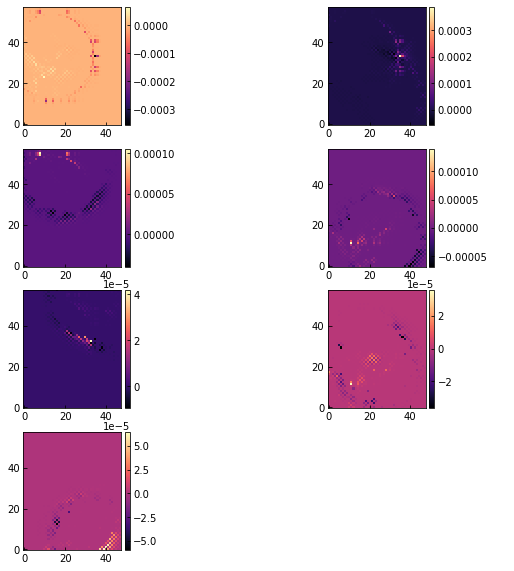

In [55]:
band = 0

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(model_vals[i][band, :, :] - output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

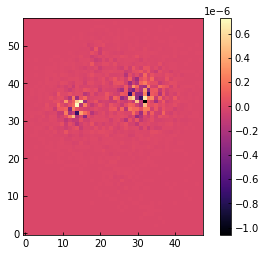

In [56]:
band = 4
plt.imshow(sum(model_vals)[band, :, :] - output.sum(axis=0)[:, :, band])
plt.colorbar()

### Compare RGBs

SCARLET Flux:  1465.6423330417801
Morpheus Flux:  1465.7124
SCARLET - Morpheus:  -0.07006930196985195
SCARLET Flux:  1847.603380196707
Morpheus Flux:  1847.5071
SCARLET - Morpheus:  0.09630011858189391
SCARLET Flux:  114.03440110314638
Morpheus Flux:  114.03871
SCARLET - Morpheus:  -0.0043104447051831585
SCARLET Flux:  47.599621878416244
Morpheus Flux:  47.609676
SCARLET - Morpheus:  -0.010054482667740672
SCARLET Flux:  23.1219556785173
Morpheus Flux:  23.119074
SCARLET - Morpheus:  0.0028818107194474862
SCARLET Flux:  24.441851671469053
Morpheus Flux:  24.453474
SCARLET - Morpheus:  -0.011622373330752112
SCARLET Flux:  13.344938994831189
Morpheus Flux:  13.34805
SCARLET - Morpheus:  -0.0031111226614868315


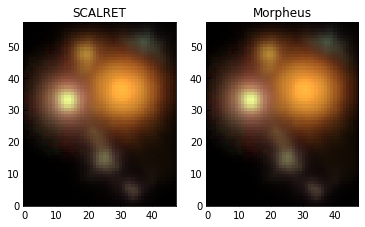

In [57]:
f, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(
    scarlet.display.img_to_rgb(
        sum(model_vals), 
        norm=norm
    )
)
ax1.set_title("SCALRET")
ax2.imshow(
    scarlet.display.img_to_rgb(
        np.transpose(
            output.sum(axis=0), 
            axes=(2, 0, 1)
        ), 
        norm=norm
    )
)
ax2.set_title("Morpheus")

for i in range(len(model_vals)):
    print("SCARLET Flux: ", model_vals[i].sum())
    print("Morpheus Flux: ", output[i, ...].sum())
    print(
        "SCARLET - Morpheus: ", 
        model_vals[i].sum() - output[i, ...].sum()
    )

### Realistically we cannot know what the SCARLET answers are, so we can comapre with the original flux too.

In [58]:
n = 5
src_centers = np.array([[c["y"], c["x"]] for c in catalog])
claim_vectors, claim_map = get_n_brightest_closest_claim_vectors_maps(model_vals, src_centers, n)

flux = np.transpose(images, axes=(1,2,0))
output_raw = decode(flux, claim_vectors, claim_map, src_centers)

100%|██████████| 13920/13920 [00:02<00:00, 5188.19it/s]


Text(0.5, 1.0, 'Morpheus')

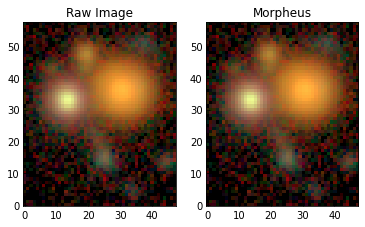

In [59]:
f, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(
    scarlet.display.img_to_rgb(images, norm=norm)
)
ax1.set_title("Raw Image")
ax2.imshow(
    scarlet.display.img_to_rgb(np.transpose(output_raw.sum(axis=0), axes=(2, 0, 1)), norm=norm)
)
ax2.set_title("Morpheus")

### Claim Vector comparison

The images look good, but the hope in using a fluw weighted encoding scheme is to make more interpretable claim vectors.

We'll borrow the encoding function from n_closest_with_vectors.ipynb do an encoding and compare the claim vector visualization from vector_coloring.ipynb

In [50]:
### FROM n_closest_with_vectors.ipynb
def get_n_closest_claim_vectors_single_pixel(
    claim_vectors: np.ndarray,     # [h, w, b, n, 2]
    claim_map: np.ndarray,         # [h, w, b, n]
    model_vals: List[np.ndarray],
    src_centers: np.ndarray,       # [n, 2]
    n: int,
    y: int,
    x: int,
    b: int,
) -> None:
    relative_vectors = src_centers - np.array([y, x]) # [n_srcs, 2]
    relative_distances = np.linalg.norm(relative_vectors, axis=-1) # [n_srcs,]
    raw_closest_sources = np.argsort(relative_distances)[:n] # [n, ]

    num_pad = n - raw_closest_sources.shape[0]
    if num_pad > 0:
        n_closest_sources = raw_closest_sources
    else:
        n_closest_sources = np.pad(raw_closest_sources, (0, num_pad), mode="edge")

    selected_srcs = relative_vectors[n_closest_sources]

    src_fluxes = np.array([max(model_vals[i][b, y, x], 0) for i in raw_closest_sources])

    sum_flux = src_fluxes.sum()
    if sum_flux > 0:
        normed_flux = src_fluxes / sum_flux
    else:
        normed_flux = np.ones([n], dtype=np.float32) / n
    
    idxs, counts = np.unique(n_closest_sources, return_counts=True)
    coefs = np.reciprocal(counts.astype(np.float32))

    claim = np.array(list(map(
        lambda i: coefs[idxs==i][0] * normed_flux[i==raw_closest_sources][0], 
        n_closest_sources
    )))  

    claim_vectors[y, x, b, ...] = selected_srcs
    claim_map[y, x, b, ...] = claim

def get_n_closest_claim_vectors(
    model_vals: List[np.ndarray], #list([b, h, w])
    src_centers: np.ndarray,
    n: int,
) -> Tuple[np.ndarray, np.ndarray]: # [h, w, b, n], [h, w, b, n, 2]
    b, y, x = model_vals[0].shape

    idxs = product(range(y), range(x), range(b))

    claim_vector = np.zeros([y, x, b, n, 2], dtype=np.float32)
    claim_map = np.zeros([y, x, b, n], dtype=np.float32)

    encode_f = partial(
        get_n_closest_claim_vectors_single_pixel,
        claim_vector,
        claim_map,
        model_vals,
        src_centers,
        n,
    )

    for _ in starmap(encode_f, tqdm(idxs, total=y*x*b)):
        pass

    return claim_vector, claim_map


In [60]:
n = 5
src_centers = np.array([[c["y"], c["x"]] for c in catalog])
n_closest_claim_vectors, n_closest_claim_map = get_n_closest_claim_vectors(model_vals, src_centers, n)

flux = np.transpose(images, axes=(1,2,0))
#output = decode(flux, claim_vectors, claim_map, src_centers)
output = decode(
    np.transpose(sum(model_vals), axes=(1,2,0)), 
    n_closest_claim_vectors, 
    n_closest_claim_map, 
    src_centers
)

100%|██████████| 13920/13920 [00:02<00:00, 6517.97it/s]


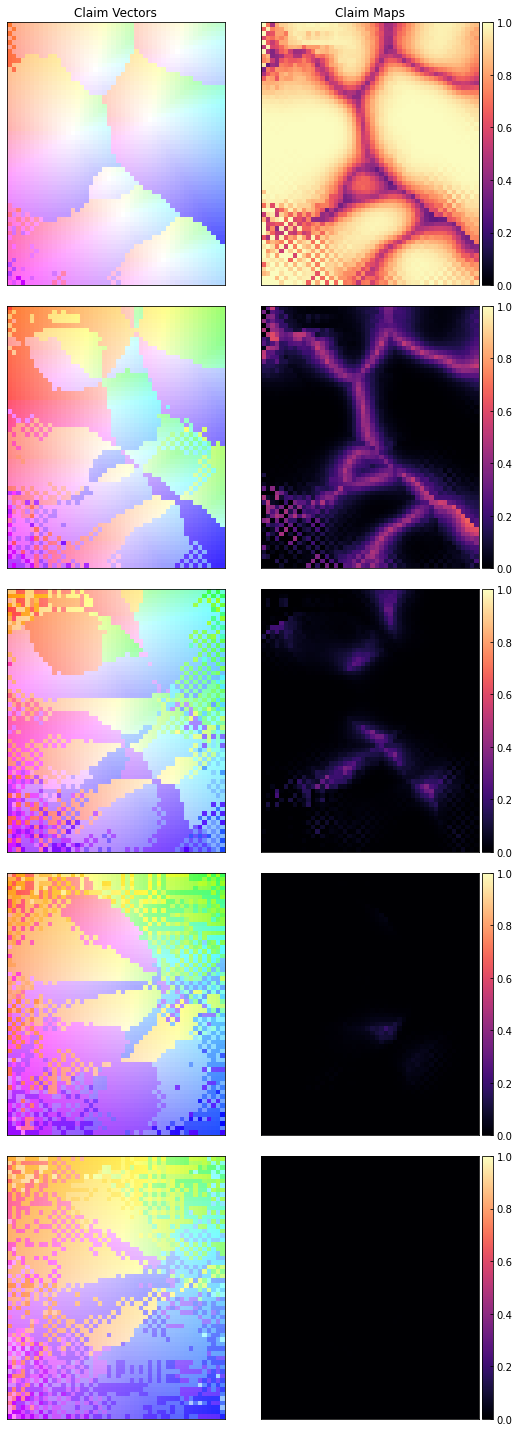

In [67]:
# n closest flux weighted

f, axes = plt.subplots(
    ncols=2,
    nrows=5,
    figsize=(8, 20),
)

for i, ax in enumerate(axes.flat):
    single_cv = claim_vectors[:, :, 0, i//2, :].copy()
    single_cv[:, :, 0]  = single_cv[:, :, 0] * -1

    # claim vector
    if i % 2 == 0:
        ax.imshow(
            flow_vis.flow_to_color(
                single_cv[..., [1, 0]],
                convert_to_bgr=False
            ),
            origin="lower"
        )
    # claim map
    else:
        img_cmap = ax.imshow(
            claim_map[:, :, 0, i//2],
            vmin=0,
            vmax=1,
            cmap="magma",
            origin="lower",
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img_cmap, cax=cax, orientation='vertical')
        
    ax.set_xticks([])
    ax.set_yticks([])

    axes[0, 0].set_title("Claim Vectors")
    axes[0, 1].set_title("Claim Maps")
    plt.tight_layout()


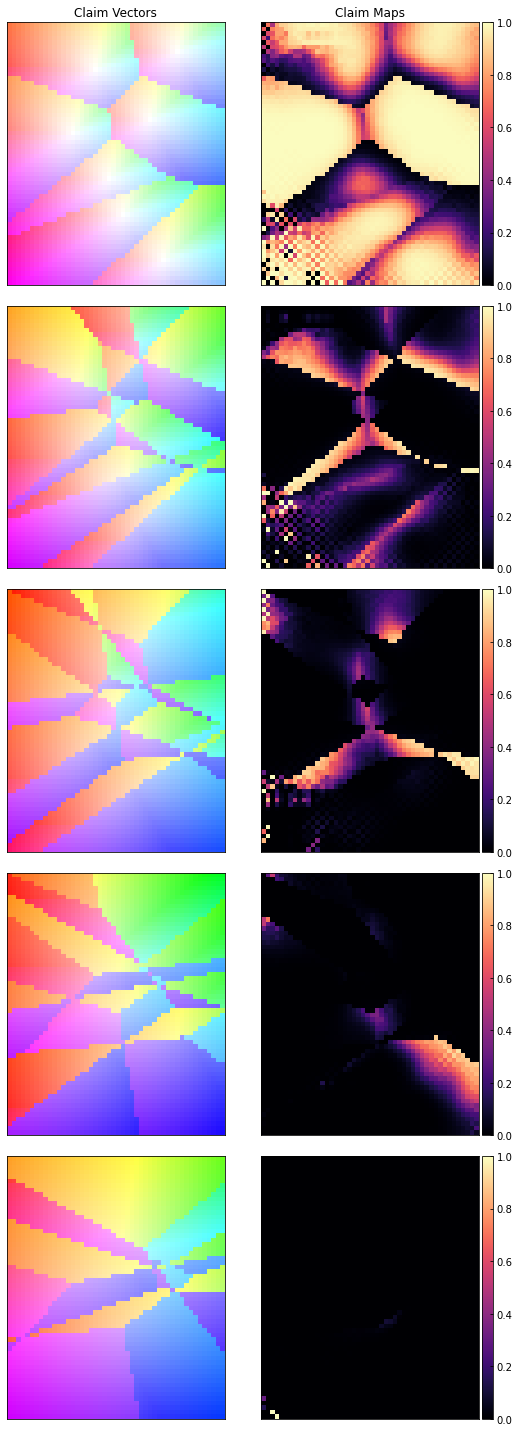

In [68]:
# n closest
f, axes = plt.subplots(
    ncols=2,
    nrows=5,
    figsize=(8, 20),
)

for i, ax in enumerate(axes.flat):
    single_cv = n_closest_claim_vectors[:, :, 0, i//2, :].copy()
    single_cv[:, :, 0]  = single_cv[:, :, 0] * -1

    # claim vector
    if i % 2 == 0:
        ax.imshow(
            flow_vis.flow_to_color(
                single_cv[..., [1, 0]],
                convert_to_bgr=False
            ),
            origin="lower"
        )
    # claim map
    else:
        img_cmap = ax.imshow(
            n_closest_claim_map[:, :, 0, i//2],
            vmin=0,
            vmax=1,
            cmap="magma",
            origin="lower",
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img_cmap, cax=cax, orientation='vertical')
        
    ax.set_xticks([])
    ax.set_yticks([])

    axes[0, 0].set_title("Claim Vectors")
    axes[0, 1].set_title("Claim Maps")
    plt.tight_layout()
